<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Capstone-Project--Trading-Evaluation-Notebook" data-toc-modified-id="Capstone-Project--Trading-Evaluation-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Capstone Project- Trading Evaluation Notebook</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Import-pickles" data-toc-modified-id="Import-pickles-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Import pickles</a></span></li></ul></li><li><span><a href="#Trading-Evaluation" data-toc-modified-id="Trading-Evaluation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Trading Evaluation</a></span><ul class="toc-item"><li><span><a href="#Create--Forecasts" data-toc-modified-id="Create--Forecasts-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create  Forecasts</a></span><ul class="toc-item"><li><span><a href="#ARIMAX-Forecasts" data-toc-modified-id="ARIMAX-Forecasts-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>ARIMAX Forecasts</a></span></li><li><span><a href="#VAR-Forecasts" data-toc-modified-id="VAR-Forecasts-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>VAR Forecasts</a></span></li><li><span><a href="#VARMAX-Forecasts" data-toc-modified-id="VARMAX-Forecasts-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>VARMAX Forecasts</a></span></li><li><span><a href="#LSTM-Forecasts" data-toc-modified-id="LSTM-Forecasts-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>LSTM Forecasts</a></span></li></ul></li><li><span><a href="#Pickle-checkpoint" data-toc-modified-id="Pickle-checkpoint-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pickle checkpoint</a></span></li><li><span><a href="#Pickle-Load" data-toc-modified-id="Pickle-Load-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Pickle Load</a></span></li><li><span><a href="#100%-Leverage-Only" data-toc-modified-id="100%-Leverage-Only-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>100% Leverage Only</a></span></li><li><span><a href="#Varying-Leverage" data-toc-modified-id="Varying-Leverage-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Varying Leverage</a></span></li></ul></li></ul></div>

# Capstone Project- Trading Evaluation Notebook
Cary Mosley, 2020

Project Overview: The goal of this project is to develop a weekly forecasting model for the S&P500 using the VIX index, a few exogenous measures of investor sentiment, and overall sentiment as calculated using New York Times headlines and article snippets. I will collect, clean, process and explore the data before building univariate, multivariate, and Long-Short Term Memory Neural Network forecasting models. I will first evaluate my models using RMSE and AIC/BIC before settling on the highest performing of each. Finally I will implement a couple different trading strategies over my test time period to see which model works best under potential real world trading implementations.

Notebook Overview: In this notebook I will create predicted spy changes using my various models. I will then implement two different trading strategies and compare the results to a baseline buy and hold strategy.

Glossary- I'm putting a few financial terms here for easy of explanation later

* Bearish: Thinking that the equity market is going to decrease in value

* Bullish: Thinking that the equity market is going to increase in value

* Long: Positive exposure to the equity market. Can be expressed in dollars or % leverage

* Short: Negative exposure to the equity market. Can be expressed in dollars or % leverage

* VIX Index- A Chicago Board of Options Exchange calculated index that measures the expected 30 day volatility in the S&P 500

## Import Libraries

In [1]:
import pandas as pd
import calendar, time
import datetime as dt
from datetime import date
from pandas.tseries.offsets import DateOffset
import numpy as np
import string, re 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

import pickle
from sklearn.externals import joblib

%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Import pickles

In [2]:
#Loading pickled dataframes
#Multivariate dataframe with SPY and VIX closing values
var_df = pd.read_pickle('../ModelPickles/var_df')
#Multivariate dataframe with SPY differenced and VIX closing values
var_vix = pd.read_pickle('../ModelPickles/var_vix')
#Multivariate dataframe with SPY differenced and VIX differenced values
var_diff = pd.read_pickle('../ModelPickles/var_diff')
#Univariate dataframe with SPY differenced values
spy_diff = pd.read_pickle('../ModelPickles/spy_diff')
#Univariate dataframe with VIX differenced values
vix_diff = pd.read_pickle('../ModelPickles/vix_diff')
#Univariate dataframe with VIX closing values
vix_df = pd.read_pickle('../ModelPickles/vix_df')
#Univariate dataframe with SPY closing values
spy_df = pd.read_pickle('../ModelPickles/spy_df')
#Final exogenous variables to align with differenced data
exog_diff = pd.read_pickle('../ModelPickles/exog_diff')
#Final exogenous variables
exog = pd.read_pickle('../ModelPickles/exog')

Lets look at the dataframes to refresh memory of what is contained

In [3]:
var_df

,Adj Close,Adj Close
Date,,
2006-06-29,96.124527,13.080000
2006-07-06,96.086758,13.705000
2006-07-13,94.830073,15.498000
2006-07-20,93.916246,17.108000
2006-07-27,95.820935,14.744000
...,...,...
2020-04-02,253.113998,53.078001
2020-04-09,270.555000,44.240000
2020-04-16,280.590009,39.606000


In [4]:
var_vix

,SPY Differenced,Adj Close
Date,,
2006-07-06,-0.037769,13.705000
2006-07-13,-1.256684,15.498000
2006-07-20,-0.913828,17.108000
2006-07-27,1.904689,14.744000
2006-08-03,0.812601,14.628000
...,...,...
2020-04-02,7.612000,53.078001
2020-04-09,17.441002,44.240000
2020-04-16,10.035009,39.606000


In [5]:
var_diff

,SPY Differenced,VIX Differenced
Date,,
2006-07-06,-0.037769,0.625000
2006-07-13,-1.256684,1.793000
2006-07-20,-0.913828,1.610000
2006-07-27,1.904689,-2.364000
2006-08-03,0.812601,-0.116000
...,...,...
2020-04-02,7.612000,-9.671999
2020-04-09,17.441002,-8.838001
2020-04-16,10.035009,-4.634000


In [6]:
spy_df

,Adj Close
Date,
2006-06-29,96.124527
2006-07-06,96.086758
2006-07-13,94.830073
2006-07-20,93.916246
2006-07-27,95.820935
...,...
2020-04-02,253.113998
2020-04-09,270.555000
2020-04-16,280.590009


In [7]:
vix_df

,Adj Close
Date,
2006-06-29,13.080000
2006-07-06,13.705000
2006-07-13,15.498000
2006-07-20,17.108000
2006-07-27,14.744000
...,...
2020-04-02,53.078001
2020-04-09,44.240000
2020-04-16,39.606000


In [8]:
spy_diff

,SPY Differenced,Lag
Date,,
2006-07-06,-0.037769,NaN
2006-07-13,-1.256684,-0.037769
2006-07-20,-0.913828,-1.256684
2006-07-27,1.904689,-0.913828
2006-08-03,0.812601,1.904689
...,...,...
2020-04-02,7.612000,6.247799
2020-04-09,17.441002,7.612000
2020-04-16,10.035009,17.441002


In [9]:
#Drop the lag column as it is no longer relevant
spy_diff.drop(columns=['Lag'],inplace=True)

In [10]:
vix_diff

,VIX Differenced
Date,
2006-07-06,0.625000
2006-07-13,1.793000
2006-07-20,1.610000
2006-07-27,-2.364000
2006-08-03,-0.116000
...,...
2020-04-02,-9.671999
2020-04-09,-8.838001
2020-04-16,-4.634000


In [11]:
exog

,Snippet_VADER,Median,Med_and_Spread,Med_and_VADER
Date,,,,
2006-06-29,0.057591,65.0,-0.760500,3.743401
2006-07-06,0.089420,20.0,-0.984000,1.788394
2006-07-13,0.119572,25.0,-0.730000,2.989307
2006-07-20,0.168046,25.0,-8.487500,4.201147
2006-07-27,0.108139,15.0,-1.221000,1.622079
...,...,...,...,...
2020-04-02,-0.031870,20.5,-3.175286,-0.653335
2020-04-09,0.071296,25.0,-2.017300,1.782407
2020-04-16,-0.057846,35.0,-2.760800,-2.024604


In [12]:
exog_diff

,Snippet_VADER,Median,Med_and_Spread,Med_and_VADER
Date,,,,
2006-07-06,0.057591,65.0,-0.760500,3.743401
2006-07-13,0.089420,20.0,-0.984000,1.788394
2006-07-20,0.119572,25.0,-0.730000,2.989307
2006-07-27,0.168046,25.0,-8.487500,4.201147
2006-08-03,0.108139,15.0,-1.221000,1.622079
...,...,...,...,...
2020-04-02,-0.002491,15.0,-2.875635,-0.037370
2020-04-09,-0.031870,20.5,-3.175286,-0.653335
2020-04-16,0.071296,25.0,-2.017300,1.782407


In [13]:
#Load models from pickles
spy_arima = joblib.load('spy_model.pkl') 
vix_arima = joblib.load('vix_model.pkl') 
var_model = joblib.load('var_model.pkl') 
varmax_model = joblib.load('varmax_model.pkl') 

In [14]:
#Set train and test dates
train_end = '2018-04'
test_start = '2018-05'

#break data into train and test sets
exog_diff_train = exog_diff[:train_end]
exog_diff_test = exog_diff[test_start:]
exog_train = exog[:train_end]
exog_test = exog[test_start:]

spy_diff_train = spy_diff[:train_end]
spy_diff_test = spy_diff[test_start:]
spy_train = pd.DataFrame(spy_df['Adj Close'][:train_end])
spy_test = pd.DataFrame(spy_df['Adj Close'][test_start:])

vix_diff_train = vix_diff[:train_end]
vix_diff_test = vix_diff[test_start:]
vix_train = pd.DataFrame(vix_df['Adj Close'][:train_end])
vix_test = pd.DataFrame(vix_df['Adj Close'][test_start:])

var_train = var_vix[:train_end]
var_test = var_vix[test_start:]
exog_train_var = exog_diff[:train_end]
exog_test_var = exog_diff[test_start:]

# Trading Evaluation

In this section I'll test various trading strategies to see how my models perform compared to a baseline.

## Create  Forecasts

First I'm going to create a list of forecasts for each of the different forecast models. Then I'll evaluate two different potential trading methods.


In [15]:
#Set train and test dates
train_end = '2018-04'
test_start = '2018-05'

### ARIMAX Forecasts

In [15]:
#This cell creates one step forward forecasts for the SPY ARIMAX model and updates the model using the new set of data

spy_diff_train_trade = spy_diff_train
exog_diff_train_trade = exog_diff_train
spy_forecasts = []
order = (1,0,1)
for i in range(0,len(spy_test)):
    #make a forecast and then append the actual value and retrain the model
    spy_forecasts.append(spy_arima.forecast(1,exog_diff_test.iloc[i])[0][0])
    spy_diff_train_trade= spy_diff_train_trade.append(pd.DataFrame(spy_diff_test[:i]))
    exog_diff_train_trade = exog_diff_train_trade.append(pd.DataFrame(exog_diff_test[:i]))
    spy_arima = ARIMA(endog = spy_diff_train_trade, exog=exog_diff_train_trade, order=order).fit()
    

    
        

### VAR Forecasts

In [17]:
#This cell creates one step forward forecasts for the multivariate VAR model and updates the model using the new set of data


var_train_trade = var_train
exog_train_trade = exog_train_var
var_forecasts = []

for i in range(0,len(vix_test)):
    #make a forecast and then append the actual value and retrain the model
    var_forecasts.append(var_model.forecast(y=var_model.y,steps=1,exog_future = pd.DataFrame(exog_test_var.iloc[i]).T)[0])
    var_train_trade= var_train_trade.append(pd.DataFrame(var_test[:i]))
    exog_train_trade = exog_train_trade.append(pd.DataFrame(exog_test_var[:i]))
    var_model = VAR(endog = var_train_trade, exog=exog_train_trade).fit(1)
    
    

In [18]:
#This cell grabs the SPY var forecasts
spy_var_forecasts=[]

for i in range(0,len(var_forecasts)):
    spy_var_forecasts.append(var_forecasts[i][0])
   

### VARMAX Forecasts

In [19]:
#This cell creates one step forward forecasts for the multivariate VARMAX model and updates the model using the new set of data

varmax_train_trade = var_train
exog_train_trade = exog_train_var
varmax_forecasts = []
order = (1,2)

for i in range(0,len(vix_test)):
    #make a forecast and then append the actual value and retrain the model
    varmax_forecasts.append(varmax_model.forecast(steps=1,exog = pd.DataFrame(exog_test_var.iloc[i]).T))
    varmax_train_trade= varmax_train_trade.append(pd.DataFrame(var_test[:i]))
    exog_train_trade = exog_train_trade.append(pd.DataFrame(exog_test_var[:i]))
    varmax_model = sm.tsa.VARMAX(endog = varmax_train_trade,order=order, exog=exog_train_trade).fit(maxiter=100)

In [20]:
#This cell grabs the SPY VARMAX forecasts
spy_varmax_forecasts=[]

for i in range(0,len(varmax_forecasts)):
    spy_varmax_forecasts.append(varmax_forecasts[i].iloc[0][0])
    

### LSTM Forecasts

In [38]:
#Load in the predicted values from the modeling notebook
spy_lstm_forecasts_val = joblib.load('spy_lstm_forecasts_val.pkl')
spy_lstm_forecasts = []

#convert values to predicted changes
for i in range(0,len(spy_lstm_forecasts_val)):
    if i==0:
        spy_lstm_forecasts.append(spy_lstm_forecasts_val[0]-spy_train.iloc[-1].item())
    else:
        spy_lstm_forecasts.append(spy_lstm_forecasts_val[i]-spy_lstm_forecasts_val[i-1])

## Pickle checkpoint

In [41]:
#pickle the forecasts
joblib.dump(spy_forecasts,'spy_forecasts.pkl')
joblib.dump(spy_var_forecasts,'spy_var_forecasts.pkl')
joblib.dump(spy_varmax_forecasts,'spy_varmax_forecasts.pkl')
joblib.dump(spy_lstm_forecasts,'spy_lstm_forecasts.pkl')

['spy_lstm_forecasts.pkl']

## Pickle Load

In [15]:
#load pickles
spy_forecasts = joblib.load('spy_forecasts.pkl')
spy_var_forecasts = joblib.load('spy_var_forecasts.pkl')
spy_varmax_forecasts = joblib.load('spy_varmax_forecasts.pkl')
spy_lstm_forecasts = joblib.load('spy_lstm_forecasts.pkl')

In [16]:
#converting the spy and vix test prices to a list of values
spy_eval = []

for i in range(0,len(spy_test)):
    spy_eval.append(spy_test.values[i].item())

first_spy = spy_train.iloc[-1].item()

## 100% Leverage Only

The first model I'll explore is one in which we go long 100% worth of the portfolio if the expected change is positive or short 100% if the predicted change is negative. The PnL is based on the next periods price compared to the current periods. For the baseline it will buy if the previous period was positive and sell if it was negative.



In [29]:


#Set initial equity to $100,000
spy_arimax_equity = 100000

spy_var_equity = 100000

spy_varmax_equity = 100000

spy_lstm_equity = 100000

hold_spy = 100000




spy_equity_df = pd.DataFrame(columns=['Buy and Hold', 'ARIMAX', 'VAR', 'VARMAX', 'LSTM'])



#This calculates the performance of SPY based on the various models
for date in range(0,len(spy_forecasts)):
    
    
    #use the previous closing price to calculate the one period % change in SPY and VIX
    if date == 0:
        spy_change_pos = 1 + (spy_eval[0]-first_spy)/first_spy
    
        spy_change_neg = 1 + (first_spy - spy_eval[0])/first_spy
        
        hold_spy = 100000 * (1+(spy_eval[0]-first_spy)/first_spy)
        
        
    else:
        spy_change_pos = 1 + (spy_eval[date] - spy_eval[date-1])/spy_eval[date-1]
        
        spy_change_neg = 1 + (spy_eval[date-1] - spy_eval[date])/spy_eval[date-1]

        hold_spy = 100000 * (1+(spy_eval[date]-spy_eval[0])/spy_eval[0])
        
    #Calculate the total equity for each spy forecast model
    #ARIMAX PnL
    if spy_forecasts[date] > 0:
        
        spy_arimax_equity = spy_arimax_equity * spy_change_pos  
    else:
        
        spy_arimax_equity = spy_arimax_equity  * spy_change_neg
    
    #VAR PnL
    if spy_var_forecasts[date] > 0:
        
        spy_var_equity = spy_var_equity * spy_change_pos    
    else:
        
        spy_var_equity = spy_var_equity  * spy_change_neg
        
    #VARMAX PnL       
    if spy_varmax_forecasts[date] > 0:
        
        spy_varmax_equity = spy_varmax_equity * spy_change_pos  
    else:
        
        spy_varmax_equity = spy_varmax_equity  * spy_change_neg
    
    #LSTM PnL
    if spy_lstm_forecasts[date] > 0:
        
        spy_lstm_equity = spy_lstm_equity * spy_change_pos  
    else:
        
        spy_lstm_equity = spy_lstm_equity  * spy_change_neg


 
    spy_equity_df = spy_equity_df.append({'Buy and Hold': round(hold_spy,0), 'ARIMAX' : round(spy_arimax_equity,0),
                                 'VAR': round(spy_var_equity,0), 'VARMAX' : round(spy_varmax_equity,0),
                                 'LSTM' : round(spy_lstm_equity,0)},ignore_index=True) 
    

In [30]:
print('Buy and Hold','$' + str(round(hold_spy,2)))
print('ARIMAX','$' + str(round(spy_arimax_equity,2)))
print('VAR','$' + str(round(spy_var_equity,2)))
print('VARMAX','$' + str(round(spy_varmax_equity,2)))
print('LSTM','$' + str(round(spy_lstm_equity,2)))


Buy and Hold $113307.1
ARIMAX $138709.45
VAR $105442.22
VARMAX $102387.67
LSTM $150514.63
Persist $500515.15


In [34]:
#Set the index
spy_equity_df.index = spy_test.index
spy_equity_df

,Buy and Hold,ARIMAX,VAR,VARMAX,LSTM
Date,,,,,
2018-05-03,99644.0,100356.0,100356.0,100356.0,100356.0
2018-05-10,102034.0,98314.0,98314.0,98314.0,102397.0
2018-05-17,102901.0,99149.0,99149.0,99149.0,103267.0
2018-05-24,103251.0,99487.0,99487.0,99487.0,102915.0
2018-05-31,102753.0,99967.0,99967.0,99967.0,103412.0
...,...,...,...,...,...
2020-04-02,99633.0,121970.0,92717.0,90032.0,151940.0
2020-04-09,106498.0,130374.0,99106.0,96235.0,141470.0
2020-04-16,110449.0,135210.0,102782.0,99805.0,146717.0


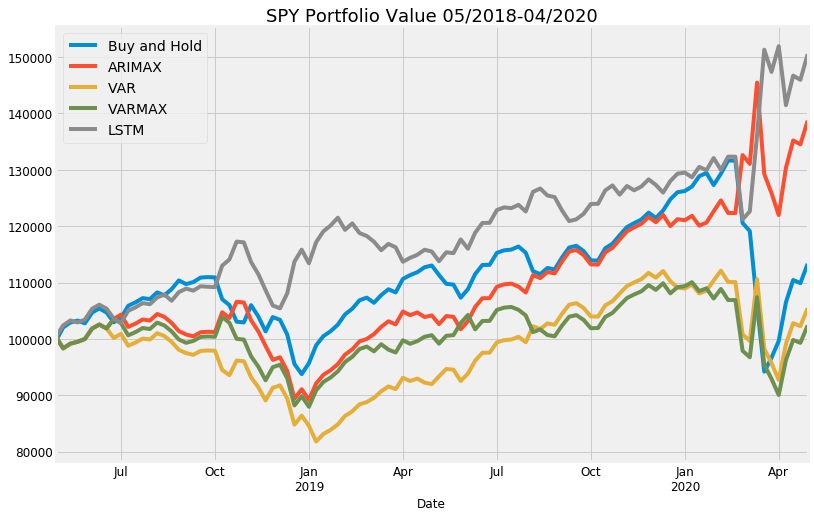

In [35]:

#Plot the PnL Over Time        
spy_equity_df.plot(figsize = (12,8), subplots=False, fontsize = 12)
plt.legend(fontsize=14, loc=2) 
plt.title("SPY Portfolio Value 05/2018-04/2020", fontsize=18);

The LSTM model performed the best with a significant outperformance compared to the other models. The ARIMAX model still performed quite well, beating the buy and hold strategy but the VAR/VARMAX models underperformed consistently. Both the LSTM and ARIMAX models seemed to do well when the market experienced downward shocks which could be an especially valuable result.

## Varying Leverage 

The second trading model I'll use to evaluate my forecasts is a varying leverage model. I'll go between -200% and 200% leverage depending on the size of my forecasted change. The leverage rules are below for positive or negative forecasts:
* Predicted change <0.5% - 50% leverage
* Predicted change 0.5%<x<1% 100% leverage
* Predicted change >1% 200% leverage

In [23]:


#Set initial equity to $100,000
spy_arimax_equity = 100000

spy_var_equity = 100000

spy_lstm_equity = 100000

spy_varmax_equity = 100000

hold_spy = 100000


spy_equity_df = pd.DataFrame(columns=['Buy and Hold', 'ARIMAX', 'VAR', 'VARMAX', 'LSTM'])



#This calculates the performance of SPY based on the various models
for date in range(0,len(spy_forecasts)):
    
    
    #use the previous closing price to calculate the one period % change in SPY and VIX
    if date == 0:
        
        spy_change_pos = (spy_eval[0]-first_spy)/first_spy
    
        spy_change_neg = (first_spy - spy_eval[0])/first_spy
        
        hold_spy = 100000 * (1+(spy_eval[0]-first_spy)/first_spy)
    else:
        spy_change_pos = (spy_eval[date] - spy_eval[date-1])/spy_eval[date-1]
        
        spy_change_neg = (spy_eval[date-1] - spy_eval[date])/spy_eval[date-1]

        hold_spy = 100000 * (1+(spy_eval[date]-spy_eval[0])/spy_eval[0])
        
    #Calculate the total equity for each spy forecast model
    #ARIMAX PnL
    if spy_forecasts[date] > 0:
        
        if (spy_forecasts[date]/spy_eval[date])<=0.005:
            spy_arimax_equity = spy_arimax_equity * (1 + spy_change_pos * .5)
            
        elif (spy_forecasts[date]/spy_eval[date])<=0.01:
            spy_arimax_equity = spy_arimax_equity * (1 + spy_change_pos * 1)
            
        else:
            spy_arimax_equity = spy_arimax_equity * (1 + spy_change_pos * 2)
            
    else:
        
        if -1*(spy_forecasts[date]/spy_eval[date])<=0.005:
            spy_arimax_equity = spy_arimax_equity * (1 + spy_change_neg * .5)
            
        elif -1*(spy_forecasts[date]/spy_eval[date])<=0.01:
            spy_arimax_equity = spy_arimax_equity * (1 + spy_change_neg * 1)
            
        else:
            spy_arimax_equity = spy_arimax_equity * (1 + spy_change_neg * 2)
    
    #VAR PnL
    if spy_var_forecasts[date] > 0:
        
        if (spy_var_forecasts[date]/spy_eval[date])<=0.005:
            spy_var_equity = spy_var_equity * (1 + spy_change_pos * .5)
            
        elif (spy_var_forecasts[date]/spy_eval[date])<=0.01:
            spy_var_equity = spy_var_equity * (1 + spy_change_pos * 1)
            
        else:
            spy_var_equity = spy_var_equity * (1 + spy_change_pos * 2)
            
    else:
        
        if -1*(spy_var_forecasts[date]/spy_eval[date])<=0.005:
            spy_var_equity = spy_var_equity * (1 + spy_change_neg * .5)
            
        elif -1*(spy_var_forecasts[date]/spy_eval[date])<=0.01:
            spy_var_equity = spy_var_equity * (1 + spy_change_neg * 1)
            
        else:
            spy_var_equity = spy_var_equity * (1 + spy_change_neg * 2)    
    
    #VARMAX PnL
    if spy_varmax_forecasts[date] > 0:
        
        if (spy_varmax_forecasts[date]/spy_eval[date])<=0.005:
            spy_varmax_equity = spy_varmax_equity * (1 + spy_change_pos * .5)
            
        elif (spy_varmax_forecasts[date]/spy_eval[date])<=0.01:
            spy_varmax_equity = spy_varmax_equity * (1 + spy_change_pos * 1)
            
        else:
            spy_varmax_equity = spy_varmax_equity * (1 + spy_change_pos * 2)
            
    else:
        
        if -1*(spy_varmax_forecasts[date]/spy_eval[date])<=0.005:
            spy_varmax_equity = spy_varmax_equity * (1 + spy_change_neg * .5)
            
        elif -1*(spy_varmax_forecasts[date]/spy_eval[date])<=0.01:
            spy_varmax_equity = spy_varmax_equity * (1 + spy_change_neg * 1)
            
        else:
            spy_varmax_equity = spy_varmax_equity * (1 + spy_change_neg * 2)
    
    #LSTM PnL
    if spy_lstm_forecasts[date] > 0:
        
        if (spy_lstm_forecasts[date]/spy_eval[date])<=0.005:
            spy_lstm_equity = spy_lstm_equity * (1 + spy_change_pos * .5)
            
        elif (spy_lstm_forecasts[date]/spy_eval[date])<=0.01:
            spy_lstm_equity = spy_lstm_equity * (1 + spy_change_pos * 1)
            
        else:
            spy_lstm_equity = spy_lstm_equity * (1 + spy_change_pos * 2)
            
    else:
        
        if -1*(spy_lstm_forecasts[date]/spy_eval[date])<=0.005:
            spy_lstm_equity = spy_lstm_equity * (1 + spy_change_neg * .5)
            
        elif -1*(spy_lstm_forecasts[date]/spy_eval[date])<=0.01:
            spy_lstm_equity = spy_lstm_equity * (1 + spy_change_neg * 1)
            
        else:
            spy_lstm_equity = spy_lstm_equity * (1 + spy_change_neg * 2)
 
    spy_equity_df = spy_equity_df.append({'Buy and Hold': round(hold_spy,0), 'ARIMAX' : round(spy_arimax_equity,0),
                                 'VAR': round(spy_var_equity,0), 'VARMAX' : round(spy_varmax_equity,0),
                                 'LSTM': round(spy_lstm_equity,0)},ignore_index=True) 
    

In [24]:
print('Buy and Hold','$' + str(round(hold_spy,2)))
print('ARIMAX','$' + str(round(spy_arimax_equity,2)))
print('VAR','$' + str(round(spy_var_equity,2)))
print('VARMAX','$' + str(round(spy_varmax_equity,2)))
print('LSTM','$' + str(round(spy_lstm_equity,2)))

Buy and Hold $113307.1
ARIMAX $111170.2
VAR $107718.93
VARMAX $106343.57
LSTM $189635.83


In [25]:
spy_equity_df

,Buy and Hold,ARIMAX,VAR,VARMAX,LSTM
0,99644.0,100178.0,100178.0,100178.0,100712.0
1,102034.0,99159.0,99159.0,99159.0,104809.0
2,102901.0,99580.0,99580.0,99580.0,106590.0
3,103251.0,99750.0,99750.0,99750.0,106408.0
4,102753.0,99990.0,99990.0,99990.0,107434.0
...,...,...,...,...,...
100,99633.0,91233.0,86820.0,85711.0,203700.0
101,106498.0,103806.0,98785.0,97523.0,175628.0
102,110449.0,105731.0,102449.0,101141.0,188656.0
103,109884.0,104650.0,101401.0,100107.0,186727.0


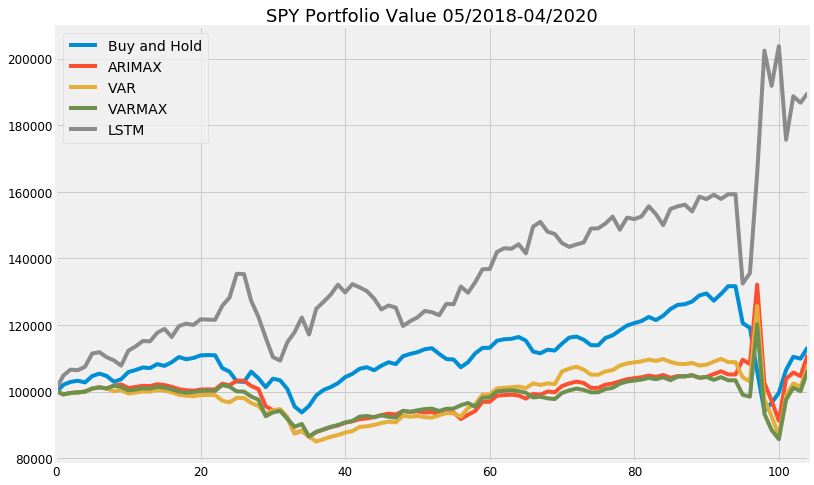

In [30]:

        
spy_equity_df.plot(figsize = (12,8), subplots=False, fontsize = 12)
plt.legend(fontsize=14, loc=2) 
plt.title("SPY Portfolio Value 05/2018-04/2020", fontsize=18);

Again, the LSTM model outperformed the rest of the herd. By scaling the leverage based on the size of the expected move, I increased overall profit quite substantially. Note that the ARIMAX model performed worse under this leveraged implementation while all of the multivariate forecasts performed better. Although the ARIMAX model performed well directionally as evidenced by the 100% leverage model, it did not perform as well when the results were related to the strength of its predictions as measured by size. The scaled LSTM model seemed to do well when the market experienced downward shocks which could be an especially valuable result.